In [76]:
import numpy as np
from PIL import Image
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt
import unittest
import csv

def read_pixel_cloud_from_csv( filename, sep=" " ):
    with open(filename, "r") as fp:
        reader = csv.reader(fp, delimiter=sep)
        for i, row in enumerate(reader):
            if i == 0:
                number_of_points = int(row[0])
                position = np.zeros( (number_of_points, 2), dtype=np.int32 )
                color    = np.zeros( (number_of_points, 3), dtype=np.float32 )  
            else:
                if len(row) != 5:
                    raise RuntimeError()
                position[i - 1] = np.array([int(pos) for pos in row[:2]])
                color[i - 1] = np.array([float(pos) for pos in row[2:]])
  
    return position, color

def create_delauney_triangulation( points ):
    triangulation = Delaunay( points )    
    return triangulation

def show_diagram( triangulation, points ):
    plt.triplot(points[:,0], points[:,1], triangulation.simplices)
    plt.plot(points[:,0], points[:,1], 'o')
    plt.show()

def compute_barycentric_coordinates( px, py, vertex_x, vertex_y ):
    x = np.array(vertex_x)
    y = np.array(vertex_y)
    detA = x[0]*y[1] + x[1]*y[2] + x[2]*y[0] - x[2]*y[1] - x[1]*y[0] - x[0]*y[2]
    detA1 = px*y[1] + x[1]*y[2] + x[2]*py - x[2]*y[1] - x[1]*py - px*y[2]
    detA2 = x[0]*py + px*y[2] + x[2]*y[0] - x[2]*py - px*y[0] - x[0]*y[2]
    detA3 = x[0]*x[1] + x[1]*py + px*y[0] - px*y[1] - x[1]*y[0] - x[0]*py

    w1 = detA1 / detA
    w2 = detA2 / detA
    w3 = detA3 / detA
    return w1, w2, w3
   
def compute_interpolated_pixel_value( px, py, vertex_positions, vertex_colors ):
    vertex_x = vertex_positions[:, 0]
    vertex_y = vertex_positions[:, 1]
    w1, w2, w3 = compute_barycentric_coordinates(px, py, vertex_x, vertex_y)
    
    scaled_colors = vertex_colors * np.array([w1, w2, w3]).reshape((-1, 1))
    interpolated_colors = np.sum(scaled_colors, axis=0)
    return tuple(interpolated_colors)

def bounding_box_of_triangle( vertex_positions ):
    min_x = vertex_positions[:, 0].min()
    max_x = vertex_positions[:, 0].max()

    min_y = vertex_positions[:, 1].min()
    max_y = vertex_positions[:, 1].max()
    
    return min_x, min_y, max_x, max_y

def get_vertex_positions( global_position_array, indices ):
    vertex_positions = np.zeros( (3, 2), dtype=np.int32 )
    vertex_positions[0,:] = global_position_array[indices[0]]
    vertex_positions[1,:] = global_position_array[indices[1]]
    vertex_positions[2,:] = global_position_array[indices[2]]
    return vertex_positions

def get_vertex_color( global_color_array, indices ):
    vertex_colors = np.zeros( (3, 3), dtype=np.float32 )
    vertex_colors[0,:] = global_color_array[indices[0]]
    vertex_colors[1,:] = global_color_array[indices[1]]
    vertex_colors[2,:] = global_color_array[indices[2]]
    return vertex_colors

def interpolate_complete_triangle( image_data, vertex_positions, vertex_colors ):
    vertex_x = vertex_positions[:, 0]
    vertex_y = vertex_positions[:, 1]
    xmin, ymin, xmax, ymax = bounding_box_of_triangle(vertex_positions)
    for x in range(xmin, xmax):
        for y in range(ymin, ymax):
            w1, w2, w3 = compute_barycentric_coordinates(x, y, vertex_x, vertex_y)
            if any([w < 0 for w in [w1, w2, w3]]):
                continue
            interpolated_colors = compute_interpolated_pixel_value(x, y, vertex_positions, vertex_colors)
            image_data[x][y] = interpolated_colors

def create_image_from_pixel_cloud( pixel_filename, image_filename ):
    image_data = np.zeros( (101, 101, 3) )

    # please extend your solution here

    image_data = np.uint8(image_data)
    image = Image.fromarray( image_data[::-1,:], mode="RGB" )
    image.save( image_filename )

test_compute_barycentric_coordinates (__main__.Aufgabenblatt2Tests) ... ok
test_compute_bbox (__main__.Aufgabenblatt2Tests) ... ok
test_compute_interpolated_pixel_value (__main__.Aufgabenblatt2Tests) ... ok
test_delauney_triangulation_by_visualisation (__main__.Aufgabenblatt2Tests) ... ok
test_interpolate_complete_triange (__main__.Aufgabenblatt2Tests) ... ok
test_read_pixel_cloud_from_csv (__main__.Aufgabenblatt2Tests) ... ok
test_read_pixel_cloud_from_csv_corrupt (__main__.Aufgabenblatt2Tests) ... ok

----------------------------------------------------------------------
Ran 7 tests in 0.378s

OK


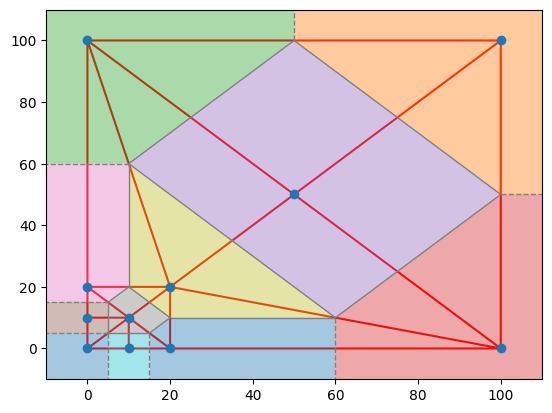

In [79]:
import unittest
from infinite_voronoi import voronoi_finite_polygons_2d

class Aufgabenblatt2Tests(unittest.TestCase):

    def test_read_pixel_cloud_from_csv(self):
        positions, colors = read_pixel_cloud_from_csv( "example.csv" )
        self.assertTupleEqual( positions.shape, (11,2) )
        self.assertEqual( positions.dtype, np.int32 )            
        self.assertTupleEqual( colors.shape, (11,3) )
        self.assertEqual( colors.dtype, np.float32 )            

    def test_read_pixel_cloud_from_csv_corrupt(self):
        self.assertRaises( RuntimeError, read_pixel_cloud_from_csv, "error.csv" )        

    def visualize_voronoi(self, points, colors):
        from scipy.spatial import Voronoi, voronoi_plot_2d
        voronoi = Voronoi( points )    
        voronoi_plot_2d( voronoi, line_colors="gray", show_points=False, show_vertices=False )

    def test_delauney_triangulation_by_visualisation(self):
        import matplotlib.pyplot as plt
        positions, colors = read_pixel_cloud_from_csv( "example.csv" )

        self.visualize_voronoi(positions, colors)
        triangulation = create_delauney_triangulation( positions )  
        plt.triplot(positions[:,0], positions[:,1], triangulation.simplices, color="red")
        plt.plot(positions[:,0], positions[:,1], 'o')

        regions, vertices = voronoi_finite_polygons_2d(positions)
        for region in regions:
            polygon = vertices[region]
            plt.fill(*zip(*polygon), alpha=0.4)
    
        plt.savefig("example_delauney.png")    

    def test_compute_barycentric_coordinates(self):
        vertex_x = [0, 2, 0 ]
        vertex_y = [0, 0, 2 ]
        w = compute_barycentric_coordinates( 1, 0, vertex_x, vertex_y )
        self.assertTupleEqual( w, (0.5,0.5,0) )
        w = compute_barycentric_coordinates( 0, 1, vertex_x, vertex_y )
        self.assertTupleEqual( w, (0.5,0,0.5) )
        w = compute_barycentric_coordinates( 1, 1, vertex_x, vertex_y )
        self.assertTupleEqual( w, (0,0.5,0.5) )

        w = compute_barycentric_coordinates(0, 0, vertex_x, vertex_y)
        self.assertTupleEqual(w, (1, 0, 0))
        self.assertEqual(np.sum(w), 1)

    def test_compute_interpolated_pixel_value(self):
        vertex_positions = np.array( [[0,0], [2,0], [0,2]], dtype=np.int32 )
        vertex_colors     = np.array( [[255,255,255], [255,0,0], [128,128,128]], dtype=np.float32 )
        color = compute_interpolated_pixel_value( 1.0, 0.0, vertex_positions, vertex_colors )
        self.assertTupleEqual( color, (255,127.5,127.5) )
        color = compute_interpolated_pixel_value( 0.0, 1.0, vertex_positions, vertex_colors )
        self.assertTupleEqual( color, (191.5,191.5,191.5) )

    def test_compute_bbox(self):
        vertex_positions = np.array( [[0,0], [2,0], [0,2]], dtype=np.int32 )
        bbox = bounding_box_of_triangle(vertex_positions)
        self.assertTupleEqual(bbox, (0, 0, 2, 2))

        vertex_positions = np.arange(6).reshape(-1, 2)
        bbox = bounding_box_of_triangle(vertex_positions)
        self.assertTupleEqual(bbox, (0, 1, 4, 5))

    def test_interpolate_complete_triange(self):
        vertex_positions = np.array( [[0, 0], [100, 0], [100, 100]], dtype=np.int32 )
        vertex_colors    = np.array( [[255, 0, 0], [0, 255, 0], [0, 0, 255]], dtype=np.float32 )
        image_data = np.full((100, 100, 3), 0, dtype=np.float32)
        interpolate_complete_triangle(image_data, vertex_positions, vertex_colors)
        image = Image.fromarray(image_data.astype(np.uint8), mode="RGB")
        image.save("interpolated.png")

unittest.main(argv=[''], verbosity=2, exit=False) 